# Online Shoppers Purchasing Intention – Final Pipeline

This notebook implements an end-to-end **classification** pipeline with:

- Advanced feature engineering (behavior ratios, intensity, indicators)
- Proper train/validation/test split (no leakage)
- Preprocessing (Yeo–Johnson for skewed numerics, scaling, one-hot encoding)
- Imbalance handling with **SMOTE (training only)** inside an imbalanced-learn pipeline
- Hyperparameter tuning for **3 algorithms**: Random Forest, XGBoost, MLP
- **Threshold optimization** on the validation set (default objective: F1)
- Final evaluation on the untouched test set


## 1. Imports, Data Load, and Advanced Feature Engineering

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import randint, uniform

In [2]:
# Load data
df = pd.read_csv("online_shoppers_intention.csv")
print("Shape:", df.shape)
df.head()


Shape: (12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
def add_advanced_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """Add behavior/intensity features. Defensive: only creates features when columns exist."""
    df = df_in.copy()

    # --- Safe helpers ---
    def safe_div(a, b):
        b0 = (b == 0)
        out = np.zeros_like(a, dtype=float)
        out[~b0] = a[~b0] / b[~b0]
        return out

    # Core page counts and durations
    page_cols = [c for c in ["Administrative", "Informational", "ProductRelated"] if c in df.columns]
    dur_cols  = [c for c in ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"] if c in df.columns]

    if page_cols:
        df["TotalPages"] = df[page_cols].sum(axis=1)

    if dur_cols:
        df["TotalDuration"] = df[dur_cols].sum(axis=1)

    # Average time per page (overall + per section)
    if "TotalDuration" in df.columns and "TotalPages" in df.columns:
        df["AvgTimePerPage"] = safe_div(df["TotalDuration"].to_numpy(), df["TotalPages"].to_numpy())

    pairs = [
        ("Administrative_Duration", "Administrative", "AvgAdminTime"),
        ("Informational_Duration", "Informational", "AvgInfoTime"),
        ("ProductRelated_Duration", "ProductRelated", "AvgProdTime"),
    ]
    for dcol, pcol, outcol in pairs:
        if dcol in df.columns and pcol in df.columns:
            df[outcol] = safe_div(df[dcol].to_numpy(), df[pcol].to_numpy())

    # PageValues intensity features
    if "PageValues" in df.columns:
        if "TotalDuration" in df.columns:
            df["PageValuesPerDuration"] = safe_div(df["PageValues"].to_numpy(), df["TotalDuration"].to_numpy())
        if "TotalPages" in df.columns:
            df["PageValuesPerPage"] = safe_div(df["PageValues"].to_numpy(), df["TotalPages"].to_numpy())

        # Indicators for strong intent signals
        df["HasPageValues"] = (df["PageValues"] > 0).astype(int)

    # Bounce/Exit interactions
    if "BounceRates" in df.columns and "ExitRates" in df.columns:
        df["ExitMinusBounce"] = (df["ExitRates"] - df["BounceRates"]).astype(float)
        df["ExitTimesBounce"] = (df["ExitRates"] * df["BounceRates"]).astype(float)

    # SpecialDay indicator
    if "SpecialDay" in df.columns:
        df["IsSpecialDay"] = (df["SpecialDay"] > 0).astype(int)

    # Weekend already boolean in many versions; create numeric copy for models if needed
    if "Weekend" in df.columns and df["Weekend"].dtype == bool:
        df["Weekend_int"] = df["Weekend"].astype(int)

    return df

df_fe = add_advanced_features(df)
print("Added columns:", sorted(set(df_fe.columns) - set(df.columns))[:30], "...")
df_fe.head()


Added columns: ['AvgAdminTime', 'AvgInfoTime', 'AvgProdTime', 'AvgTimePerPage', 'ExitMinusBounce', 'ExitTimesBounce', 'HasPageValues', 'IsSpecialDay', 'PageValuesPerDuration', 'PageValuesPerPage', 'TotalDuration', 'TotalPages', 'Weekend_int'] ...


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,AvgAdminTime,AvgInfoTime,AvgProdTime,PageValuesPerDuration,PageValuesPerPage,HasPageValues,ExitMinusBounce,ExitTimesBounce,IsSpecialDay,Weekend_int
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0,0.00,0.040,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0.0,0.0,32.000000,0.0,0.0,0,0.10,0.000,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0,0.00,0.040,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0.0,0.0,1.333333,0.0,0.0,0,0.09,0.007,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0.0,0.0,62.750000,0.0,0.0,0,0.03,0.001,0,1


## 2. Train/Validation/Test Split (No Leakage)

In [4]:
# Target
X = df_fe.drop("Revenue", axis=1)
y_raw = df_fe["Revenue"]

# Encode target (True/False -> 1/0)
le = LabelEncoder()
y = le.fit_transform(y_raw)

# 70/15/15 split via two-step stratified split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=67, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, random_state=67, stratify=y_trainval
)  # 0.1765 * 0.85 ≈ 0.15

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Class ratio (train):", np.bincount(y_train))
print("Class ratio (val):  ", np.bincount(y_val))
print("Class ratio (test): ", np.bincount(y_test))


Train: (8630, 30) Val: (1850, 30) Test: (1850, 30)
Class ratio (train): [7294 1336]
Class ratio (val):   [1564  286]
Class ratio (test):  [1564  286]


## 3. Preprocessing + SMOTE (Training Only) with Imbalanced-Learn Pipeline

In [ ]:
# Identify feature types
target_col = "Revenue"

# Base numeric columns from original dataset (plus engineered numeric features)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Columns that are typically right-skewed in this dataset (and derived ratios can also be skewed)
skew_candidates = [
    "Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", "PageValues",
    "TotalDuration", "AvgTimePerPage", "AvgAdminTime", "AvgInfoTime", "AvgProdTime",
    "PageValuesPerDuration", "PageValuesPerPage"
]
skewed_features = [c for c in skew_candidates if c in numeric_cols]
other_numerical = [c for c in numeric_cols if c not in skewed_features]

categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Build preprocessing
numeric_skew_pipe = ImbPipeline(steps=[
    ("yeojohnson", PowerTransformer(method="yeo-johnson")),
    ("scaler", StandardScaler()),
])

numeric_other_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
])

try:
    _ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    _ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_pipe = ImbPipeline(steps=[
    ("onehot", _ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num_skew", numeric_skew_pipe, skewed_features),
        ("num_other", numeric_other_pipe, other_numerical),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop"
)

smote = SMOTE(random_state=67)


## 4. Model Tuning (3 Algorithms)

In [6]:
def evaluate_with_threshold(y_true, y_proba, threshold=0.5, name="Model"):
    y_pred = (y_proba >= threshold).astype(int)
    print(f"=== {name} @ threshold={threshold:.3f} ===")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC (Average Precision): {average_precision_score(y_true, y_proba):.4f}")
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
    }

def find_best_threshold(y_true, y_proba, metric="f1", grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 181)

    best = {"threshold": 0.5, "score": -np.inf, "precision": None, "recall": None, "f1": None}
    for t in grid:
        y_pred = (y_proba >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        if metric == "f1":
            score = f1
        elif metric == "precision":
            score = p
        elif metric == "recall":
            score = r
        else:
            raise ValueError("metric must be one of: f1, precision, recall")

        if score > best["score"]:
            best = {"threshold": float(t), "score": float(score), "precision": float(p), "recall": float(r), "f1": float(f1)}
    return best

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)


In [7]:
# --- Model 1: Random Forest ---
rf = RandomForestClassifier(
    random_state=67,
    n_jobs=-1,
    class_weight=None  # we rely on SMOTE for imbalance handling to keep interpretation consistent
)

rf_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("model", rf),
])

rf_param = {
    "model__n_estimators": randint(300, 900),
    "model__max_depth": randint(4, 20),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", None],
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param,
    n_iter=20,
    scoring="f1",
    cv=cv,
    random_state=67,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)
print("RF best params:", rf_search.best_params_)
print("RF best CV F1:", rf_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
RF best params: {'model__max_depth': 15, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 364}
RF best CV F1: 0.679833816877894


In [8]:
# --- Model 2: XGBoost ---
xgb = XGBClassifier(
    random_state=67,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1
)

xgb_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("model", xgb),
])

xgb_param = {
    "model__n_estimators": randint(300, 1200),
    "model__max_depth": randint(2, 8),
    "model__learning_rate": uniform(0.01, 0.25),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__min_child_weight": randint(1, 10),
    "model__gamma": uniform(0.0, 0.5),
    "model__reg_alpha": uniform(0.0, 1.0),
    "model__reg_lambda": uniform(0.5, 2.0),
}

xgb_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=xgb_param,
    n_iter=25,
    scoring="f1",
    cv=cv,
    random_state=67,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_train, y_train)
print("XGB best params:", xgb_search.best_params_)
print("XGB best CV F1:", xgb_search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
XGB best params: {'model__colsample_bytree': np.float64(0.8989324707807154), 'model__gamma': np.float64(0.29443614217351666), 'model__learning_rate': np.float64(0.019301485355305396), 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 417, 'model__reg_alpha': np.float64(0.23892003940767348), 'model__reg_lambda': np.float64(0.5616931622154733), 'model__subsample': np.float64(0.6842265400851839)}
XGB best CV F1: 0.6761503729309164


In [9]:
# --- Model 3: MLP (Neural Network) ---
mlp = MLPClassifier(
    random_state=67,
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

mlp_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("model", mlp),
])

mlp_param = {
    "model__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
    "model__alpha": uniform(1e-5, 5e-3),
    "model__learning_rate_init": uniform(1e-4, 5e-3),
}

mlp_search = RandomizedSearchCV(
    mlp_pipe,
    param_distributions=mlp_param,
    n_iter=15,
    scoring="f1",
    cv=cv,
    random_state=67,
    n_jobs=-1,
    verbose=1
)

mlp_search.fit(X_train, y_train)
print("MLP best params:", mlp_search.best_params_)
print("MLP best CV F1:", mlp_search.best_score_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
MLP best params: {'model__alpha': np.float64(0.004825411080156877), 'model__hidden_layer_sizes': (128,), 'model__learning_rate_init': np.float64(0.00031204124122848114)}
MLP best CV F1: 0.6393927379130309


## 5. Validation-Based Threshold Optimization and Final Test Evaluation

In [ ]:
# Collect best estimators
best_models = {
    "RandomForest": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_,
    "MLP": mlp_search.best_estimator_,
}

# Evaluate each on validation (probabilities), then tune threshold on validation (optimize F1)
val_results = {}

for name, mdl in best_models.items():
    y_val_proba = mdl.predict_proba(X_val)[:, 1]
    base = evaluate_with_threshold(y_val, y_val_proba, threshold=0.5, name=f"{name} (VAL, default)")
    best_t = find_best_threshold(y_val, y_val_proba, metric="f1")
    tuned = evaluate_with_threshold(y_val, y_val_proba, threshold=best_t["threshold"], name=f"{name} (VAL, tuned)")
    val_results[name] = {"default": base, "best_threshold": best_t, "tuned": tuned}

val_results


=== RandomForest (VAL, default) @ threshold=0.500 ===
              precision    recall  f1-score   support

           0     0.9822    0.9501    0.9659      1564
           1     0.7685    0.9056    0.8315       286

    accuracy                         0.9432      1850
   macro avg     0.8754    0.9279    0.8987      1850
weighted avg     0.9491    0.9432    0.9451      1850

Confusion matrix:
 [[1486   78]
 [  27  259]]
ROC AUC: 0.9866
PR AUC (Average Precision): 0.9396
=== RandomForest (VAL, tuned) @ threshold=0.665 ===
              precision    recall  f1-score   support

           0     0.9642    0.9827    0.9734      1564
           1     0.8945    0.8007    0.8450       286

    accuracy                         0.9546      1850
   macro avg     0.9294    0.8917    0.9092      1850
weighted avg     0.9535    0.9546    0.9536      1850

Confusion matrix:
 [[1537   27]
 [  57  229]]
ROC AUC: 0.9866
PR AUC (Average Precision): 0.9396
=== XGBoost (VAL, default) @ threshold=0.500 =

In [40]:
# Select final model + threshold (based on VAL tuned F1)

final_model_name = max(val_results.keys(), key=lambda k: val_results[k]["tuned"]["f1"])
final_threshold = float(val_results[final_model_name]["best_threshold"]["threshold"])

print("Selected final model:", final_model_name)
print("Selected threshold (from VAL):", final_threshold)


# Define utilities: threshold sweep + plotting

def threshold_sweep_metrics(y_true, y_proba, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.0, 1.0, 201)  # step=0.005
    prec, rec, f1 = [], [], []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        prec.append(p); rec.append(r); f1.append(f)

    return thresholds, np.array(prec), np.array(rec), np.array(f1)

def plot_threshold_curves(y_true, y_proba, title_prefix="", selected_threshold=None):
    thresholds, prec, rec, f1 = threshold_sweep_metrics(y_true, y_proba)

    best_idx = int(np.argmax(f1))
    best_t = float(thresholds[best_idx])
    best_f1 = float(f1[best_idx])

    plt.figure(figsize=(9, 5))
    plt.plot(thresholds, prec, label="Precision")
    plt.plot(thresholds, rec, label="Recall")
    plt.plot(thresholds, f1, label="F1")

    # F1-optimal for THIS proba array
    plt.axvline(best_t, linestyle="--", label=f"Best F1 threshold ≈ {best_t:.3f}")

    # The threshold you actually selected for reporting/deployment
    if selected_threshold is not None:
        plt.axvline(float(selected_threshold), linestyle="-.", label=f"Selected threshold = {float(selected_threshold):.3f}")

    plt.title(f"{title_prefix} Threshold Sweep Curves")
    plt.xlabel("Threshold")
    plt.ylabel("Metric value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # PR curve
    p_curve, r_curve, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(r_curve, p_curve, label=f"PR curve (AP={ap:.3f})")
    plt.title(f"{title_prefix} Precision–Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return {"best_threshold_by_f1": best_t, "best_f1": best_f1, "ap": float(ap)}


# Model snapshots
#    - model_val: used for VAL plots (DO NOT refit)
#    - model_final: clone + refit on train+val for TEST eval

model_val = best_models[final_model_name]    # should be the train-fitted best estimator
model_final = clone(model_val)              # fresh copy to avoid mutating model_val
model_final.fit(X_trainval, y_trainval)     # refit for final TEST evaluation

# -----------------------------
# Evaluate on TEST (using model_final)
# -----------------------------
y_test_proba = model_final.predict_proba(X_test)[:, 1]

print("\n--- TEST: default threshold 0.5 ---")
test_default = evaluate_with_threshold(
    y_test, y_test_proba, threshold=0.5, name=f"{final_model_name} (TEST, default)"
)

print("\n--- TEST: tuned threshold (from VAL) ---")
test_tuned = evaluate_with_threshold(
    y_test, y_test_proba, threshold=final_threshold, name=f"{final_model_name} (TEST, tuned)"
)

print("\nDelta (tuned - default):")
for k in ["precision", "recall", "f1", "roc_auc", "pr_auc"]:
    print(f"{k}: {test_tuned[k] - test_default[k]:+.4f}")

Selected final model: RandomForest
Selected threshold (from VAL): 0.6649999999999999

--- TEST: default threshold 0.5 ---
=== RandomForest (TEST, default) @ threshold=0.500 ===
              precision    recall  f1-score   support

           0     0.9649    0.9130    0.9382      1564
           1     0.6324    0.8182    0.7134       286

    accuracy                         0.8984      1850
   macro avg     0.7986    0.8656    0.8258      1850
weighted avg     0.9135    0.8984    0.9035      1850

Confusion matrix:
 [[1428  136]
 [  52  234]]
ROC AUC: 0.9431
PR AUC (Average Precision): 0.7591

--- TEST: tuned threshold (from VAL) ---
=== RandomForest (TEST, tuned) @ threshold=0.665 ===
              precision    recall  f1-score   support

           0     0.9414    0.9457    0.9435      1564
           1     0.6953    0.6783    0.6867       286

    accuracy                         0.9043      1850
   macro avg     0.8184    0.8120    0.8151      1850
weighted avg     0.9034    0.904

## Threshold–Metric Curves (Validation & Test)

This section visualizes how **Precision / Recall / F1** change as we sweep the decision threshold.
It helps you justify why the tuned threshold is chosen (instead of relying on the default 0.5), and is a common “advanced” deliverable in classification projects.



--- Threshold curves: VAL (selection snapshot) ---


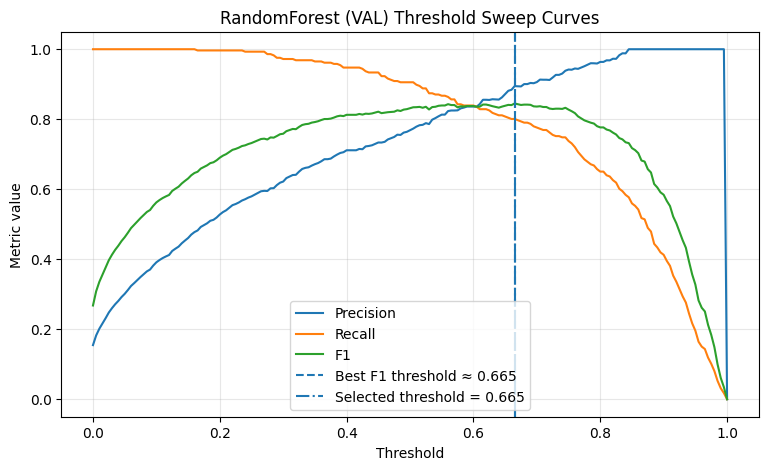

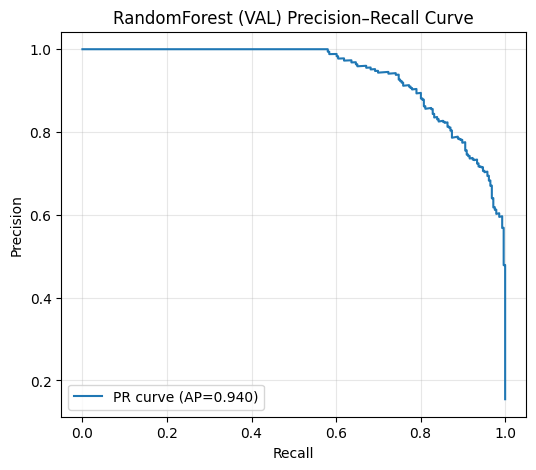


--- Threshold curves: TEST (diagnostic only) ---


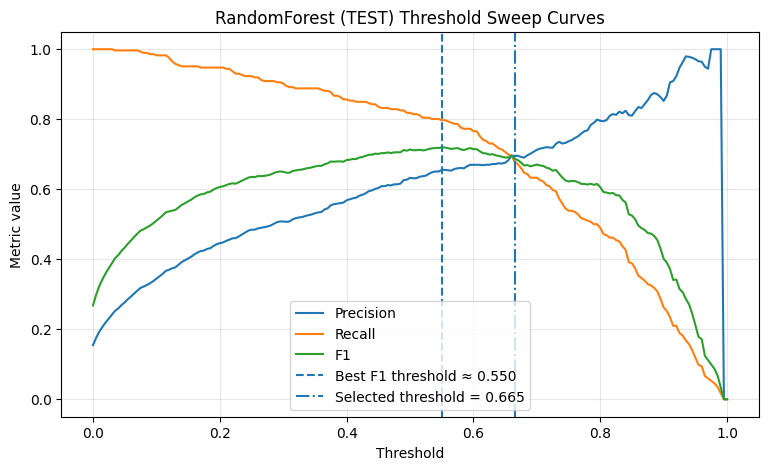

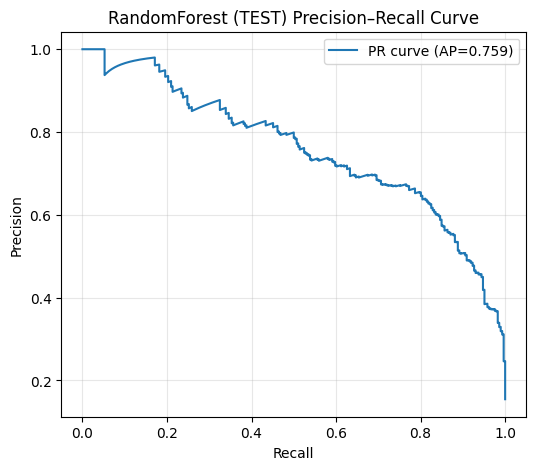

In [ ]:
#  Plot VAL curves (using model_val) and TEST curves (using model_final)
print("\n--- Threshold curves: VAL (selection snapshot) ---")
y_val_proba = model_val.predict_proba(X_val)[:, 1]
val_curve_info = plot_threshold_curves(
    y_val, y_val_proba,
    title_prefix=f"{final_model_name} (VAL)",
    selected_threshold=final_threshold
)

print("\n--- Threshold curves: TEST (diagnostic only) ---")
test_curve_info = plot_threshold_curves(
    y_test, y_test_proba,
    title_prefix=f"{final_model_name} (TEST)",
    selected_threshold=final_threshold
)

## Error Analysis (Test Set)

This section explains **where the model fails** by profiling **False Positives (FP)** and **False Negatives (FN)** on the test set.
The outputs below are designed to be directly reusable in your report:

- counts / rates of TP, TN, FP, FN at the tuned threshold  
- top numeric-feature shifts for FP vs TN and FN vs TP  
- categorical distributions for common categorical features (if present)


In [ ]:
def build_error_frame(X, y_true, y_proba, threshold, label_prefix=""):
    df_err = X.copy()
    # Ensure index alignment
    df_err = df_err.reset_index(drop=True)
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_proba = pd.Series(y_proba).reset_index(drop=True)

    df_err[f"{label_prefix}y_true"] = y_true
    df_err[f"{label_prefix}proba"] = y_proba
    df_err[f"{label_prefix}y_pred"] = (y_proba >= threshold).astype(int)

    # Confusion categories
    yt = df_err[f"{label_prefix}y_true"]
    yp = df_err[f"{label_prefix}y_pred"]
    df_err[f"{label_prefix}confusion"] = np.select(
        [
            (yt==1) & (yp==1),
            (yt==0) & (yp==0),
            (yt==0) & (yp==1),
            (yt==1) & (yp==0),
        ],
        ["TP","TN","FP","FN"],
        default="?"
    )
    return df_err

def confusion_report(df_err, confusion_col):
    counts = df_err[confusion_col].value_counts().reindex(["TP","TN","FP","FN"]).fillna(0).astype(int)
    total = int(counts.sum())
    rates = (counts / total).round(4)
    out = pd.DataFrame({"count": counts, "rate": rates})
    return out

def top_numeric_shifts(df_err, group_a, group_b, numeric_cols, confusion_col, top_n=12):
    # Compare group_a vs group_b: (mean_a - mean_b) / std_b as a simple standardized shift
    a = df_err[df_err[confusion_col]==group_a][numeric_cols]
    b = df_err[df_err[confusion_col]==group_b][numeric_cols]
    if len(a)==0 or len(b)==0:
        return pd.DataFrame()
    mean_a = a.mean(numeric_only=True)
    mean_b = b.mean(numeric_only=True)
    std_b = b.std(numeric_only=True).replace(0, np.nan)

    shift = (mean_a - mean_b) / std_b
    res = pd.DataFrame({
        "mean_"+group_a: mean_a,
        "mean_"+group_b: mean_b,
        "std_"+group_b: std_b,
        "std_shift": shift
    }).sort_values("std_shift", key=lambda s: s.abs(), ascending=False)
    return res.head(top_n)

def categorical_profile(df_err, cat_col, confusion_col, top_k=10):
    # Frequency table per confusion group
    tab = (df_err
           .groupby([confusion_col, cat_col])
           .size()
           .rename("count")
           .reset_index())
    # Normalize within each confusion group
    tab["share_within_group"] = tab.groupby(confusion_col)["count"].transform(lambda x: x / x.sum())
    # Top categories by overall frequency
    top_vals = df_err[cat_col].value_counts().head(top_k).index
    tab = tab[tab[cat_col].isin(top_vals)].sort_values([confusion_col, "share_within_group"], ascending=[True, False])
    return tab

# Build error frame using tuned threshold (the one chosen on VAL)
df_err = build_error_frame(X_test, y_test, y_test_proba, threshold=final_threshold, label_prefix="test_")

print("Confusion breakdown @ tuned threshold:")
display(confusion_report(df_err, "test_confusion"))

# Identify numeric vs categorical columns in engineered feature set
added_cols = {"test_y_true","test_proba","test_y_pred"}  # exclude from feature lists
feature_cols = [c for c in df_err.columns if c not in added_cols and c!="test_confusion"]

numeric_cols = df_err[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in numeric_cols]

print("\nNumeric feature count:", len(numeric_cols))
print("Categorical feature count:", len(cat_cols))

# Top numeric shifts
print("\nTop numeric shifts: FP vs TN (what makes negatives become predicted positive?)")
fp_vs_tn = top_numeric_shifts(df_err, "FP", "TN", numeric_cols, "test_confusion", top_n=15)
display(fp_vs_tn)

print("\nTop numeric shifts: FN vs TP (what makes positives get missed?)")
fn_vs_tp = top_numeric_shifts(df_err, "FN", "TP", numeric_cols, "test_confusion", top_n=15)
display(fn_vs_tp)

# Categorical profiling (only if there are categorical features)
if len(cat_cols) > 0:
    print("\nCategorical profiles (top categories) by confusion group:")
    for c in cat_cols[:6]:  # avoid overly long output
        print(f"\n--- {c} ---")
        display(categorical_profile(df_err, c, "test_confusion", top_k=8))
else:
    print("\nNo categorical features detected in X_test after feature engineering.")


Confusion breakdown @ tuned threshold:


,count,rate
test_confusion,,
TP,232,0.1254
TN,1431,0.7735
FP,133,0.0719
FN,54,0.0292



Numeric feature count: 27
Categorical feature count: 3

Top numeric shifts: FP vs TN (what makes negatives become predicted positive?)


,mean_FP,mean_TN,std_TN,std_shift
PageValuesPerDuration,0.014791,0.000147,0.000998,14.672712
PageValuesPerPage,0.556206,0.005729,0.045937,11.983330
PageValues,19.041619,0.323952,1.858188,10.073077
HasPageValues,0.857143,0.049616,0.217225,3.717461
TotalPages,70.000000,27.708595,36.029101,1.173812
TotalDuration,2820.366809,1044.728022,1569.682802,1.131209
ProductRelated,63.864662,25.333333,34.121461,1.129240
ProductRelated_Duration,2578.973379,948.091911,1481.667659,1.100707
Administrative,4.932331,1.965059,3.045604,0.974280
Informational,1.203008,0.410203,1.170204,0.677493



Top numeric shifts: FN vs TP (what makes positives get missed?)


,mean_FN,mean_TP,std_TP,std_shift
HasPageValues,0.203704,0.965517,0.182860,-4.166100
PageValues,1.126859,34.910861,37.938014,-0.890505
ExitRates,0.026975,0.017045,0.012297,0.807488
ExitMinusBounce,0.018534,0.012852,0.008246,0.689094
PageValuesPerPage,0.019641,1.897983,3.192139,-0.588427
BounceRates,0.008441,0.004193,0.007995,0.531296
PageValuesPerDuration,0.000421,0.057080,0.121054,-0.468053
ExitTimesBounce,0.000303,0.000145,0.000486,0.325128
Informational_Duration,97.996561,53.480643,160.550731,0.277270
AvgProdTime,35.745243,41.593089,22.439854,-0.260601



Categorical profiles (top categories) by confusion group:

--- Month ---


,test_confusion,Month,count,share_within_group
4,FN,Nov,31,0.574074
0,FN,Aug,7,0.129630
2,FN,Jul,5,0.092593
5,FN,Oct,5,0.092593
1,FN,Dec,3,0.055556
3,FN,May,2,0.037037
6,FN,Sep,1,0.018519
12,FP,Nov,64,0.481203
11,FP,May,27,0.203008
10,FP,Mar,18,0.135338



--- VisitorType ---


,test_confusion,VisitorType,count,share_within_group
1,FN,Returning_Visitor,45,0.833333
0,FN,New_Visitor,9,0.166667
3,FP,Returning_Visitor,124,0.932331
2,FP,New_Visitor,9,0.067669
6,TN,Returning_Visitor,1229,0.858840
4,TN,New_Visitor,191,0.133473
5,TN,Other,11,0.007687
9,TP,Returning_Visitor,180,0.775862
7,TP,New_Visitor,51,0.219828
8,TP,Other,1,0.004310



--- Weekend ---


,test_confusion,Weekend,count,share_within_group
0,FN,False,34,0.629630
1,FN,True,20,0.370370
2,FP,False,105,0.789474
3,FP,True,28,0.210526
4,TN,False,1119,0.781971
5,TN,True,312,0.218029
6,TP,False,171,0.737069
7,TP,True,61,0.262931


In [14]:
best_rf_pipeline = rf_search.best_estimator_


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(
    estimator=best_rf_pipeline,
    method="isotonic",   
    cv=None
)

calibrated_rf.fit(X_val, y_val)

# calibrated probabilities
y_val_proba_cal = calibrated_rf.predict_proba(X_val)[:, 1]
y_test_proba_cal = calibrated_rf.predict_proba(X_test)[:, 1]

In [16]:
y_val_proba_cal.shape, y_test_proba_cal.shape


((1850,), (1850,))

In [ ]:
COST_FP = 1.0
COST_FN = 5.0

def expected_cost(y_true, y_pred):
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return COST_FP * fp + COST_FN * fn

thresholds = np.linspace(0.1, 0.9, 81)
costs = []

for t in thresholds:
    y_pred = (y_val_proba_cal >= t).astype(int)
    costs.append(expected_cost(y_val, y_pred))

best_t_cost = thresholds[np.argmin(costs)]
best_t_cost


np.float64(0.24000000000000002)

In [18]:
from sklearn.metrics import classification_report

y_test_pred_cost = (y_test_proba_cal >= best_t_cost).astype(int)

print(f"Cost-optimal threshold: {best_t_cost:.3f}")
print(classification_report(y_test, y_test_pred_cost, digits=4))


Cost-optimal threshold: 0.240
              precision    recall  f1-score   support

           0     0.9631    0.9022    0.9317      1564
           1     0.6026    0.8112    0.6915       286

    accuracy                         0.8881      1850
   macro avg     0.7829    0.8567    0.8116      1850
weighted avg     0.9074    0.8881    0.8945      1850



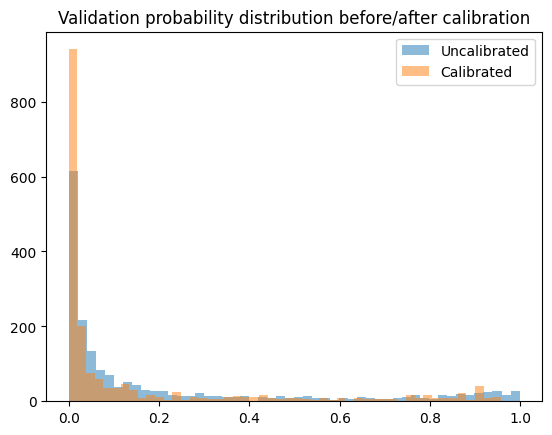

In [ ]:
# Compare uncalibrated vs calibrated probability distribution
plt.hist(best_rf_pipeline.predict_proba(X_val)[:,1], bins=50, alpha=0.5, label="Uncalibrated")
plt.hist(y_val_proba_cal, bins=50, alpha=0.5, label="Calibrated")
plt.legend()
plt.title("Validation probability distribution before/after calibration")
plt.show()


VAL cost-optimal threshold = 0.240, expected cost = 124.00


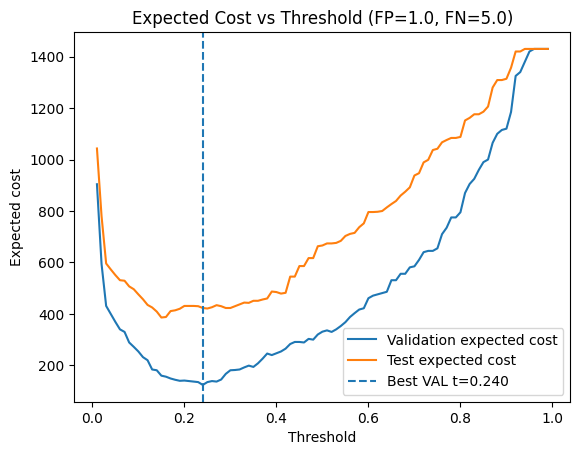

In [ ]:
# 1) define threshold grid
thresholds = np.linspace(0.01, 0.99, 99)

# 2) compute expected cost on VAL and TEST
val_costs = []
test_costs = []

for t in thresholds:
    y_val_pred = (y_val_proba_cal >= t).astype(int)
    val_costs.append(expected_cost(y_val, y_val_pred))

    y_test_pred = (y_test_proba_cal >= t).astype(int)
    test_costs.append(expected_cost(y_test, y_test_pred))

val_costs = np.array(val_costs)
test_costs = np.array(test_costs)

best_idx = np.argmin(val_costs)
best_t = thresholds[best_idx]
best_val_cost = val_costs[best_idx]

print(f"VAL cost-optimal threshold = {best_t:.3f}, expected cost = {best_val_cost:.2f}")

# 3) plot
plt.figure()
plt.plot(thresholds, val_costs, label="Validation expected cost")
plt.plot(thresholds, test_costs, label="Test expected cost")
plt.axvline(best_t, linestyle="--", label=f"Best VAL t={best_t:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Expected cost")
plt.title(f"Expected Cost vs Threshold (FP={COST_FP}, FN={COST_FN})")
plt.legend()
plt.show()


In [ ]:
def learn_group_thresholds_cost(
    X_val_df: pd.DataFrame,
    y_val: pd.Series,
    y_val_proba: np.ndarray,
    group_col: str,
    thresholds: np.ndarray,
    min_group_size: int = 80
):
    """
    Learn cost-optimal threshold per group on validation set.
    Correctly handles non-consecutive DataFrame indices by using label alignment.
    """
    # --- Safety checks ---
    if not isinstance(X_val_df, pd.DataFrame):
        raise TypeError("X_val_df must be a pandas DataFrame (with group columns).")
    if not isinstance(y_val, (pd.Series, pd.DataFrame)):
        raise TypeError("y_val must be a pandas Series (aligned to X_val_df).")
    if len(X_val_df) != len(y_val) or len(X_val_df) != len(y_val_proba):
        raise ValueError("X_val_df, y_val, y_val_proba must have the same length.")

    # Make sure y_val is Series with same index as X_val_df
    if isinstance(y_val, pd.DataFrame):
        if y_val.shape[1] != 1:
            raise ValueError("y_val DataFrame must have exactly one column.")
        y_val = y_val.iloc[:, 0]
    if not y_val.index.equals(X_val_df.index):
        # Align by index labels
        y_val = y_val.reindex(X_val_df.index)

    # --- Global fallback threshold (VAL) ---
    global_costs = []
    y_val_np = y_val.to_numpy()
    for t in thresholds:
        global_costs.append(expected_cost(y_val_np, (y_val_proba >= t).astype(int)))
    global_best_t = float(thresholds[int(np.argmin(global_costs))])

    # --- Group thresholds ---
    t_map = {}
    stats = []

    groups = X_val_df[group_col].astype(str)

    # groupby preserves original index labels -> perfect for .loc
    for g, idx_labels in groups.groupby(groups).groups.items():
        idx_labels = list(idx_labels)  # index labels (may be non-consecutive)
        n = len(idx_labels)

        if n < min_group_size:
            t_map[g] = global_best_t
            stats.append((g, n, global_best_t, "fallback_small_group"))
            continue

        # Extract group y and proba by index alignment
        y_g = y_val.loc[idx_labels].to_numpy()

        # Convert index labels -> positional indices for y_val_proba
        pos = X_val_df.index.get_indexer(idx_labels)
        if (pos < 0).any():
            raise ValueError("Index alignment failed: some group indices not found in X_val_df.index.")
        p_g = y_val_proba[pos]

        costs_g = []
        for t in thresholds:
            costs_g.append(expected_cost(y_g, (p_g >= t).astype(int)))
        best_t_g = float(thresholds[int(np.argmin(costs_g))])

        t_map[g] = best_t_g
        stats.append((g, n, best_t_g, "learned"))

    stats_df = pd.DataFrame(stats, columns=[group_col, "n_val", "threshold", "status"])
    stats_df = stats_df.sort_values(["status", "n_val"], ascending=[True, False])

    return t_map, global_best_t, stats_df

def apply_group_thresholds(
    X_df: pd.DataFrame,
    proba: np.ndarray,
    group_col: str,
    t_map: dict,
    global_t: float
):
    groups = X_df[group_col].astype(str).values
    t_used = np.array([t_map.get(g, global_t) for g in groups], dtype=float)
    y_pred = (proba >= t_used).astype(int)
    return y_pred, t_used

In [ ]:
# Ensure X_val / X_test are DataFrames
assert hasattr(X_val, "index") and hasattr(X_test, "index"), "X_val/X_test must be pandas DataFrame."

# Convert y_val / y_test to pandas Series aligned with X_val/X_test
if isinstance(y_val, np.ndarray) or isinstance(y_val, list):
    y_val = pd.Series(np.array(y_val).ravel(), index=X_val.index, name="target")
elif isinstance(y_val, pd.Series):
    y_val = y_val.reindex(X_val.index)
elif isinstance(y_val, pd.DataFrame):
    y_val = y_val.iloc[:, 0].reindex(X_val.index)

if isinstance(y_test, np.ndarray) or isinstance(y_test, list):
    y_test = pd.Series(np.array(y_test).ravel(), index=X_test.index, name="target")
elif isinstance(y_test, pd.Series):
    y_test = y_test.reindex(X_test.index)
elif isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0].reindex(X_test.index)

print("Types:", type(y_val), type(y_test))
print("Index aligned (val/test):", y_val.index.equals(X_val.index), y_test.index.equals(X_test.index))


Types: <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Index aligned (val/test): True True


In [ ]:
threshold_grid = np.linspace(0.05, 0.95, 91)

# Learn thresholds on VAL
month_t_map, month_global_t, month_stats = learn_group_thresholds_cost(
    X_val_df=X_val,
    y_val=y_val,
    y_val_proba=y_val_proba_cal,
    group_col="Month",
    thresholds=threshold_grid,
    min_group_size=80
)

print("Global threshold (VAL):", month_global_t)
display(month_stats.head(20))

# Apply on TEST
y_test_pred_month, t_used_month = apply_group_thresholds(
    X_df=X_test,
    proba=y_test_proba_cal,
    group_col="Month",
    t_map=month_t_map,
    global_t=month_global_t
)

print("=== TEST performance (Month-segmented thresholds, cost-optimized on VAL) ===")
print(classification_report(y_test, y_test_pred_month, digits=4))

# Compare expected cost (TEST)
test_cost_month = expected_cost(y_test, y_test_pred_month)
test_cost_global = expected_cost(y_test, (y_test_proba_cal >= month_global_t).astype(int))
print(f"TEST expected cost: month_segmented={test_cost_month:.2f}, global={test_cost_global:.2f}")


Global threshold (VAL): 0.24


,Month,n_val,threshold,status
3,Jul,77,0.24,fallback_small_group
0,Aug,70,0.24,fallback_small_group
9,Sep,64,0.24,fallback_small_group
4,June,50,0.24,fallback_small_group
2,Feb,22,0.24,fallback_small_group
6,May,498,0.47,learned
7,Nov,457,0.24,learned
5,Mar,269,0.40,learned
1,Dec,262,0.20,learned
8,Oct,81,0.25,learned


=== TEST performance (Month-segmented thresholds, cost-optimized on VAL) ===
              precision    recall  f1-score   support

           0     0.9566    0.9156    0.9356      1564
           1     0.6261    0.7727    0.6917       286

    accuracy                         0.8935      1850
   macro avg     0.7913    0.8442    0.8137      1850
weighted avg     0.9055    0.8935    0.8979      1850

TEST expected cost: month_segmented=457.00, global=423.00


In [24]:
visitor_t_map, visitor_global_t, visitor_stats = learn_group_thresholds_cost(
    X_val_df=X_val,
    y_val=y_val,
    y_val_proba=y_val_proba_cal,
    group_col="VisitorType",
    thresholds=threshold_grid,
    min_group_size=80
)

display(visitor_stats)

y_test_pred_visitor, t_used_visitor = apply_group_thresholds(
    X_df=X_test,
    proba=y_test_proba_cal,
    group_col="VisitorType",
    t_map=visitor_t_map,
    global_t=visitor_global_t
)

print("=== TEST performance (VisitorType-segmented thresholds) ===")
print(classification_report(y_test, y_test_pred_visitor, digits=4))

print("TEST expected cost (visitor segmented):", expected_cost(y_test, y_test_pred_visitor))
print("TEST expected cost (global):", expected_cost(y_test, (y_test_proba_cal >= visitor_global_t).astype(int)))


,VisitorType,n_val,threshold,status
1,Other,11,0.24,fallback_small_group
2,Returning_Visitor,1578,0.28,learned
0,New_Visitor,261,0.18,learned


=== TEST performance (VisitorType-segmented thresholds) ===
              precision    recall  f1-score   support

           0     0.9626    0.9041    0.9324      1564
           1     0.6063    0.8077    0.6927       286

    accuracy                         0.8892      1850
   macro avg     0.7844    0.8559    0.8125      1850
weighted avg     0.9075    0.8892    0.8953      1850

TEST expected cost (visitor segmented): 425.0
TEST expected cost (global): 423.0


In [25]:
threshold_grid = np.linspace(0.05, 0.95, 91)

# global threshold on VAL
global_costs = [
    expected_cost(y_val, (y_val_proba_cal >= t).astype(int))
    for t in threshold_grid
]
t_global = float(threshold_grid[np.argmin(global_costs)])

t_global


0.24

In [26]:
# mask for November on VAL
nov_mask_val = X_val["Month"].astype(str) == "Nov"

y_val_nov = y_val.loc[nov_mask_val]
p_val_nov = y_val_proba_cal[X_val.index.get_indexer(y_val_nov.index)]

nov_costs = []
for t in threshold_grid:
    nov_costs.append(
        expected_cost(y_val_nov.to_numpy(), (p_val_nov >= t).astype(int))
    )

t_nov_raw = float(threshold_grid[np.argmin(nov_costs)])
t_nov_raw


0.24

In [27]:
alpha = 0.4

t_nov_shrunk = alpha * t_nov_raw + (1 - alpha) * t_global

t_global, t_nov_raw, t_nov_shrunk


(0.24, 0.24, 0.24)

In [28]:
# apply policy on TEST
nov_mask_test = X_test["Month"].astype(str) == "Nov"

y_test_pred_policy4 = np.zeros_like(y_test, dtype=int)

# Nov: shrunk threshold
y_test_pred_policy4[nov_mask_test] = (
    y_test_proba_cal[nov_mask_test] >= t_nov_shrunk
).astype(int)

# Other months: global threshold
y_test_pred_policy4[~nov_mask_test] = (
    y_test_proba_cal[~nov_mask_test] >= t_global
).astype(int)


In [ ]:

print("=== TEST: Policy P4 (Nov-only + Shrinkage) ===")
print(f"t_global = {t_global:.3f}, t_nov_raw = {t_nov_raw:.3f}, t_nov_shrunk = {t_nov_shrunk:.3f}")
print(classification_report(y_test, y_test_pred_policy4, digits=4))

cost_policy4 = expected_cost(y_test, y_test_pred_policy4)
cost_global = expected_cost(y_test, (y_test_proba_cal >= t_global).astype(int))

print(f"Expected cost — Policy P4: {cost_policy4:.2f}")
print(f"Expected cost — Global cost-opt: {cost_global:.2f}")


=== TEST: Policy P4 (Nov-only + Shrinkage) ===
t_global = 0.240, t_nov_raw = 0.240, t_nov_shrunk = 0.240
              precision    recall  f1-score   support

           0     0.9631    0.9022    0.9317      1564
           1     0.6026    0.8112    0.6915       286

    accuracy                         0.8881      1850
   macro avg     0.7829    0.8567    0.8116      1850
weighted avg     0.9074    0.8881    0.8945      1850

Expected cost — Policy P4: 423.00
Expected cost — Global cost-opt: 423.00
